In [1]:
import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import sys
import numpy as np

import mbuild
import foyer

import parmed
import parmed.unit as u

import openmm.app
import openmm 

import pandas as pd
import matplotlib.pyplot as plt

d:\CondaEnvs\MolModel\lib\site-packages\mbuild\recipes\__init__.py:13: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entry_points = metadata.entry_points()["mbuild.plugins"]


In [ ]:
class MSDReporter:
    def __init__(self, interval, simulation, dt):
        self.interval = interval
        state0 = simulation.context.getState(getPositions=True,
                                             enforcePeriodicBox=False)
        self.x0 = state0.getPositions(asNumpy=True).value_in_unit(u.centimeter)
        self.dt = dt.value_in_unit(u.second)
        self.label = dict(Time=[], MSD=[])

    def describeNextReport(self, simulation):
        steps = self.interval - simulation.currentStep % self.interval
        return (steps, True, False, False, False, False)

    def report(self, simulation, state):
        x = state.getPositions(asNumpy=True).value_in_unit(u.centimeter)
        msd = np.mean(np.linalg.norm((x - self.x0), axis=1)**2)
        time = state.getStepCount() * self.dt
        self.label['Time'].append(time)
        self.label['MSD'].append(msd)

In [ ]:
# butanol1 = parmed.load_file(r'Butanol-1\Structure.pdb')
# _ff = foyer.Forcefield(r'Butanol-1\FF.xml')
# # _ff = foyer.forcefields.load_OPLSAA()
# butanol1 = _ff.apply(butanol1)

In [2]:
oplsaa = foyer.forcefields.load_OPLSAA()

# butanol1 = mbuild.load(r'Butanol-1\Structure_simple.pdb')
butanol1 = mbuild.load('CCCCO',smiles=True)
butanol1.energy_minimize()
butanol1.name = 'Butanol'

ocm2 = mbuild.load(r'OCM-2\Structure_simple.pdb')
ocm2 = mbuild.load('CC(C)C(OCCOC(OCCOCCOC(OCCOC(C(C)C)=O)=O)=O)=O',smiles=True)
ocm2.energy_minimize()
ocm2.name = 'OCM'

d:\CondaEnvs\MolModel\lib\site-packages\mbuild\compound.py:2829: UserWarning: Performing energy minimization using the Open Babel package. Please refer to the documentation to find the appropriate citations for Open Babel and the UFF force field
  warn(


In [3]:
## Combined box structure
print('Build butanol-1 box')
box_but = mbuild.Box([5, 5, 5])

box_but2 = mbuild.fill_box(
    box=box_but,
    compound=butanol1,
    n_compounds=100,
)
print('Build ocm-2 box')
box_ocm = mbuild.Box([5, 5, 5])
box_ocm2 = mbuild.fill_box(
    box=box_ocm,
    compound=ocm2,
    n_compounds=100,
)

print('Appling on butanol')
box_but3 = oplsaa.apply(box_but2)

print('Appling on ocm')
box_ocm3 = oplsaa.apply(box_ocm2)

print('Combining')
structure = box_ocm3 + box_but3

Build butanol-1 box
Build ocm-2 box
Appling on butanol


d:\CondaEnvs\MolModel\lib\site-packages\foyer\forcefield.py:349: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 1600, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)


Appling on ocm


d:\CondaEnvs\MolModel\lib\site-packages\foyer\forcefield.py:349: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 6000, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)
d:\CondaEnvs\MolModel\lib\site-packages\foyer\forcefield.py:926: UserWarning: Parametrized structure has non-zero charge.Structure's total charge: -16.000000000000284
  warnings.warn(


Combining


In [ ]:
## Filled box structure
# box = mbuild.fill_box(
#     compound=[butanol1,ocm2],
#     compound_ratio=[0.5,0.5],
#     box=[5,5,5],
#     density=1000
# )

box = mbuild.Box([5, 5, 5])
box2 = mbuild.fill_box(
    compound=ocm2,
    n_compounds=100,
    box=box,
)
box3 = mbuild.solvate(solute=box2, solvent=butanol1, n_solvent=100, box=box)
structure = oplsaa.apply(box3)

In [ ]:
structure.save('initial.pdb')

In [4]:
structure.residues[0].name='ocm'
structure.residues[1].name='butanol'

In [52]:
system = structure.createSystem(
    nonbondedMethod=openmm.app.PME,
    constraints=None,
    # implicitSolvent=openmm.app.GBn2,
    implicitSolventSaltConc=0.1 * u.moles / u.liter,
    removeCMMotion=True,
)


In [53]:
integrator = openmm.LangevinIntegrator(
    300 * u.kelvin,  # Temperature of heat bath
    1.0 / u.picoseconds,  # Friction coefficient
    2.0 * u.femtoseconds,  # Time step
)
simulation = openmm.app.Simulation(
    structure.topology,
    system,
    integrator,
    openmm.Platform.getPlatformByName('CUDA'),
)
simulation.context.setPositions(structure.positions)
simulation.minimizeEnergy(maxIterations=500)

In [54]:
simulation.reporters.append(
    openmm.app.StateDataReporter(
        sys.stdout,
        10000,
        step=True,
        # potentialEnergy=True,
        # kineticEnergy=True,
        # temperature=True,
    ))

rep_D = openmm.app.DCDReporter(
    'traj.dcd',
    100,
    # enforcePeriodicBox=False,
)
simulation.reporters.append(rep_D)

rep_pdb = openmm.app.PDBReporter('system.pdb',100)
simulation.reporters.append(rep_pdb)

# rep_old = MSDReporter(100, simulation, 2.0 * u.femtosecond)
# simulation.reporters.append(rep_old)

In [55]:
simulation.step(1000000)

#"Step"
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000


In [11]:
simulation.currentStep

90470

# trajectory

In [57]:
import mdtraj

In [56]:
trajectory = mdtraj.load_pdb('system.pdb')

NameError: name 'mdtraj' is not defined

In [ ]:
trajectory.superpose()

In [ ]:
a= mdtraj.rmsd(trajectory,trajectory,0)

In [ ]:
trajectory

# trajectory2

In [58]:
import MDAnalysis
import MDAnalysis.analysis.rms

In [59]:
trajectory = MDAnalysis.Universe('system.pdb')
# trajectory=MDAnalysis.Universe(simulation)

In [40]:
list(trajectory.residues)

[<Residue ocm, 1>, <Residue but, 2>]

In [60]:
trajectory.trajectory

<PDBReader system.pdb with 10000 frames of 7400 atoms>

In [61]:
RMSD_analysis = MDAnalysis.analysis.rms.RMSD(
    trajectory,
    trajectory,
    # select="backbone",
    groupselections=["resid 1", "resid 2"])

In [62]:
RMSD_analysis.run()

d:\CondaEnvs\MolModel\lib\site-packages\MDAnalysis\analysis\base.py:447: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time
d:\CondaEnvs\MolModel\lib\site-packages\MDAnalysis\coordinates\base.py:753: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.time


In [63]:
result = RMSD_analysis.results.rmsd.T

In [64]:
step = result[0]
time = result[1]
msd_all = result[2]
msd_ocm = result[3]
msd_but = result[4]

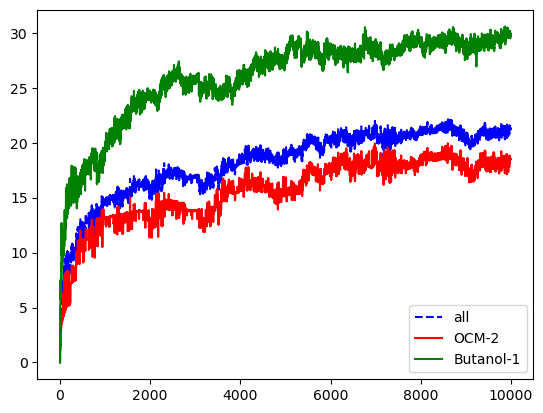

In [65]:
plt.plot(time, msd_all, 'b--', label="all")
plt.plot(time, msd_ocm, 'r', label="OCM-2")
plt.plot(time, msd_but, 'g', label="Butanol-1")
plt.legend()

In [66]:
from scipy.stats import linregress

In [67]:
regress = linregress(time,msd_ocm)
D_A = regress.slope/6

regress = linregress(time,msd_but)
D_B = regress.slope/6

regress = linregress(time,msd_all)
D_all = regress.slope/6
print(D_A,D_B,D_all)

0.00014818384425891717 0.00019555888516038455 0.00015734848317974816
